Setups

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color
from skimage.util import img_as_float
from scipy import signal
#do filter, conversion and Fourier Transform

Load the pic, convert to float point and transform color space to grayscale

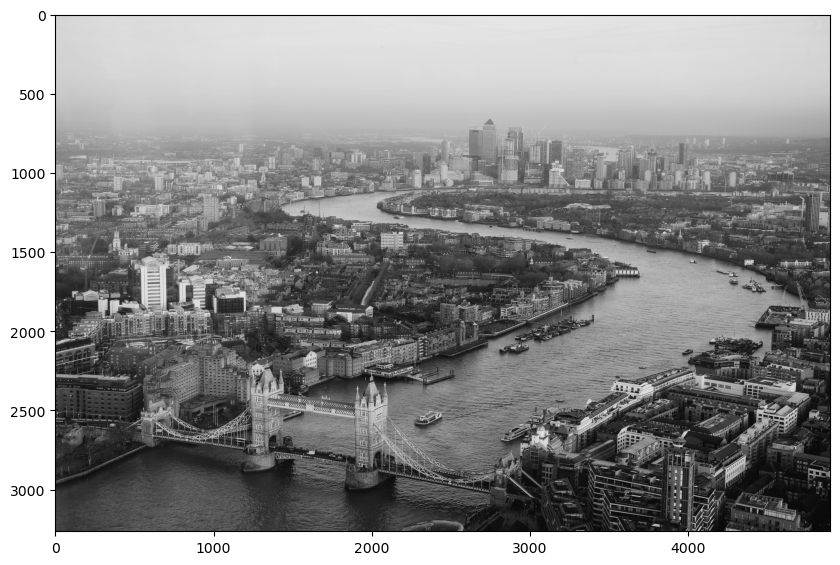

In [2]:
image = img_as_float(io.imread('data/resources/london.jpg'))
image = color.rgb2gray(image)
#show
plt.figure(figsize=(10, 7.5))
plt.imshow(image, cmap='gray')
plt.show()

Creat a Gaussian Kernel
$$G[m, n] = \frac{1}{C} \cdot e^{-\frac{m^2 + n^2}{2\sigma^2}} \text{ with } C = \sum_{m, n} e^{-\frac{m^2 + n^2}{2\sigma^2}},$$

where $C$ normalizes the filter kernel to prevent intensity scaling.

Using this function, generate a large Gaussian kernel with `width=201` and `sigma=10`. Plot the kernel.

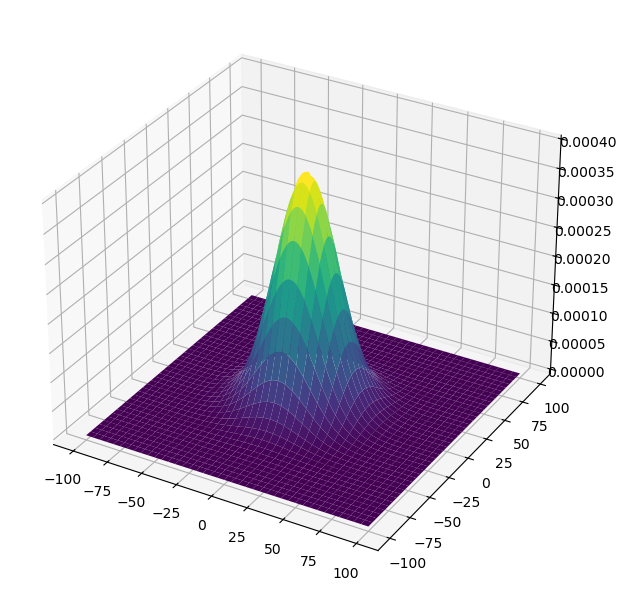

In [3]:
#for gaussian kernel, we need width and sigma for scale and standard deviation
def gaussian_kernel(width,sigma):
    m, n = np.mgrid[:width, :width] - ((width-1)/2)
#locate the center point
    kernel = np.exp(-(np.square(m)+np.square(n))/(2*np.square(sigma)))
#kernel need to be normalized to keep the intensity
    kernel_normalized = kernel / np.sum(kernel)
    return kernel_normalized

width = 201
sigma = 20
kernel = gaussian_kernel(width,sigma)

#show the 3D surface
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(7.5, 7.5))
ax = fig.add_subplot(111, projection='3d')
#111 means 1x1x1 grids, plot 3d 
m, n = np.mgrid[:width, :width] - ((width-1)/2)
ax.plot_surface(m, n, kernel, cmap='viridis')
#draw the surface
plt.show()

Filter the image with rhe kernel, should be blurry

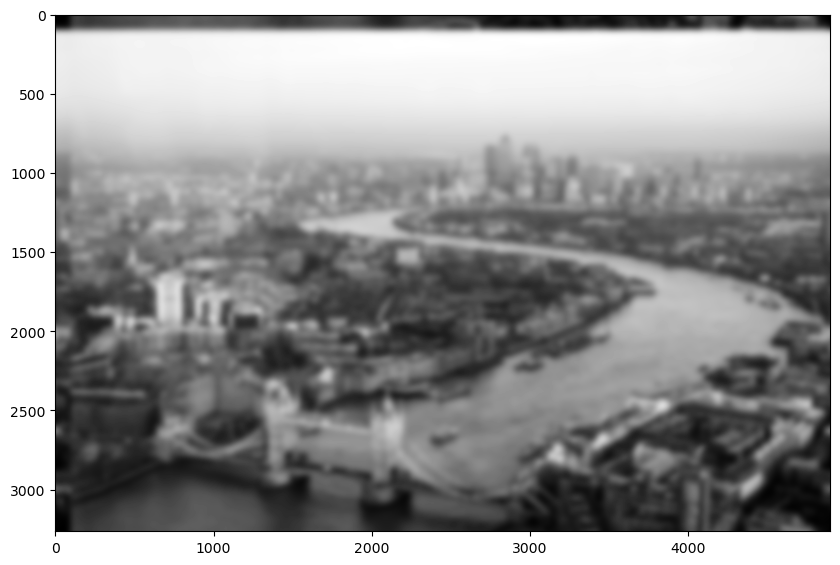

In [4]:
def filter_image(image, kernel_padded):
    image_fft = np.fft.fft2(image)# image in frequency domain
    kernel_fft = np.fft.fft2(kernel_padded)# kernel in frequency domain
    image_filtered_fft = image_fft * kernel_fft# multiply in frequency
    image_filtered = np.fft.ifft2(image_filtered_fft).real# inverse fft to space domain, only use the real part
    return image_filtered
#do the padded kernel
kernel_pad_rows = image.shape[0] - width
kernel_pad_cols = image.shape[1] - width
kernel_padded = np.pad(kernel, ((0,kernel_pad_rows),(0,kernel_pad_cols)))

image_filtered = filter_image(image, kernel_padded)
#show the result
plt.figure(figsize=(10, 7.5))
plt.imshow(image_filtered, cmap='gray')
plt.show()

Because the DFT assume the signal to be periodic, the filter kernel will include the first side when in the end, brings shift to the pic.(see the black line on the top, and strange strip on the left), the is set (0, 0) to be the center of the kernel

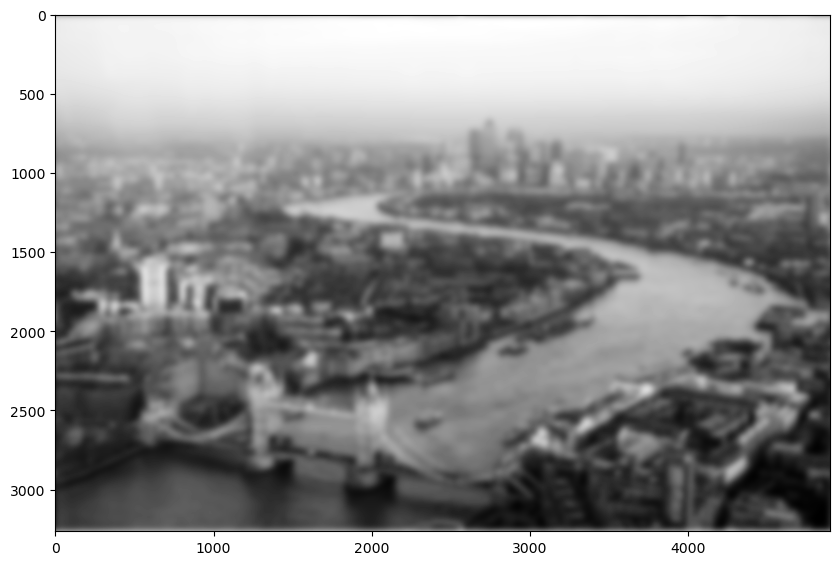

In [5]:
#same kernel padding
kernel_pad_rows = image.shape[0] - width
kernel_pad_cols = image.shape[1] - width
kernel_padded = np.pad(kernel, ((0,kernel_pad_rows),(0,kernel_pad_cols)))
#we do the roll in 2 dimension, half width each
kernel_padded_casual = np.roll(np.roll(kernel_padded, -(width-1)//2, axis=0), -(width-1)//2, axis=1)

image_filtered = filter_image(image, kernel_padded_casual)
#plot the pic
plt.figure(figsize=(10, 7.5))
plt.imshow(image_filtered, cmap='gray')
plt.show()

Still some artifacts on the borden, it is because the implicit circular convolution, we can pad the pic with half the filter size, to make sure nopixels from other side influence the result

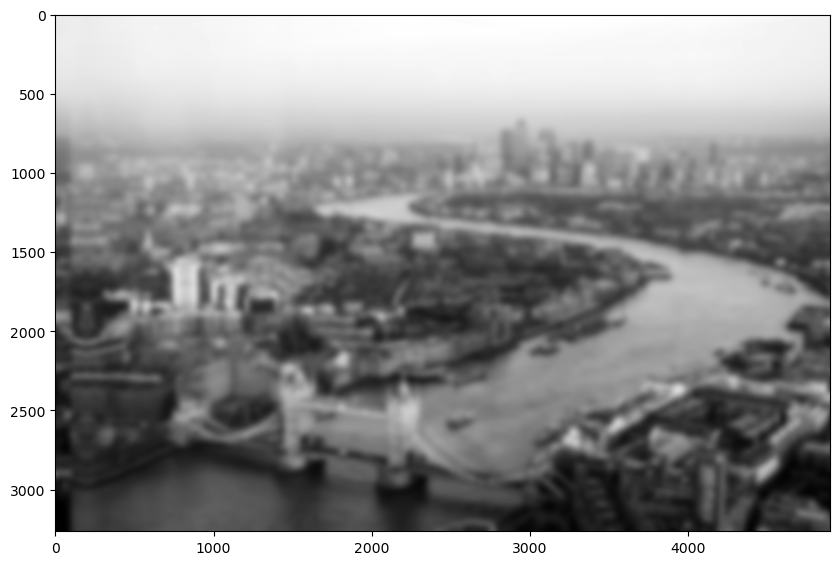

In [6]:
image_pad_width = (width - 1) // 2
image_padded = np.pad(image, ((image_pad_width, image_pad_width),(image_pad_width, image_pad_width)), mode='symmetric')
#kernel should match the size
kernel_pad_rows = image_padded.shape[0] - width
kernel_pad_cols = image_padded.shape[1] - width
kernel_padded = np.pad(kernel, ((0,kernel_pad_rows),(0,kernel_pad_cols)))
#do the roll
kernel_padded_casual = np.roll(np.roll(kernel_padded, -(width-1)//2, axis=0), (width-1)//2, axis=1)

image_filtered_padded = filter_image(image_padded, kernel_padded_casual)
#slice the correct pic. size
image_filtered = image_filtered_padded[image_pad_width:-image_pad_width, image_pad_width:-image_pad_width]
#plot
plt.figure(figsize=(10, 7.5))
plt.imshow(image_filtered, cmap='gray')
plt.show()